<a href="https://colab.research.google.com/github/kavyajeetbora/EAST/blob/master/EAST_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Imports

[**Tasks - Incidental Scene Text**](https://rrc.cvc.uab.es/?ch=4&com=tasks)

In [0]:
import os
import time
from PIL import Image
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import shutil
from google.colab import files
from zipfile import ZipFile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:
%%time
%cd ..
directory = '/content/cloned-repo'
if os.path.exists(directory):
  shutil.rmtree(directory)

!git clone -l -s git://github.com/kavyajeetbora/EAST.git /content/cloned-repo
%cd /content/cloned-repo
!ls

/content
Cloning into '/content/cloned-repo'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 225 (delta 12), reused 0 (delta 0), pack-reused 199
Receiving objects: 100% (225/225), 17.97 MiB | 22.83 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/cloned-repo
dataset.py		    EAST_resnet_detection.ipynb  loss.py
detect.py		    EAST_resnet.py		 model.py
dsiplay_ground_truth.ipynb  EAST_resnet_training.ipynb	 model_resnet.py
EAST_detection.ipynb	    EAST_training.ipynb		 train.py
CPU times: user 116 ms, sys: 390 ms, total: 506 ms
Wall time: 5.37 s


In [0]:
from dataset import *

In [20]:
def unzip_files(file,output_dir):
  with ZipFile(file, 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall(output_dir)
  print('Extracted',len(output_dir),'to output dir')

image_files = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/AI4Bharat Dataset/Training Set/Images/Images.Zip'
annotation_files = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/AI4Bharat Dataset/Training Set/Annotations/Annotations.Zip'

directory = 'Train Set'
if os.path.exists(directory):
  shutil.rmtree(directory)
  
os.mkdir('Train Set')
print('Created Directory')

Created Directory


In [21]:
%%time
unzip_files(image_files, output_dir='Train Set/Images')

Extracted 16 to output dir
CPU times: user 1.15 s, sys: 365 ms, total: 1.52 s
Wall time: 1.52 s


In [22]:
%%time
unzip_files(annotation_files, output_dir='Train Set/Annotations')

Extracted 21 to output dir
CPU times: user 802 ms, sys: 685 ms, total: 1.49 s
Wall time: 1.49 s


In [23]:
print(len(os.listdir('Train Set/Images')))

5000


In [24]:
print(len(os.listdir('Train Set/Annotations')))

5000


In [25]:
%%time
# AI4Bharat dataset
image_folder = 'Train Set/Images'
label_folder = 'Train Set/Annotations'

training_dataset = custom_dataset(image_folder, label_folder)
print(len(training_dataset))

5000
CPU times: user 16.7 ms, sys: 5.77 ms, total: 22.5 ms
Wall time: 22.7 ms


## Loss for one batch

In [26]:
%%time
train_loader = DataLoader(training_dataset, shuffle = True, batch_size=8, drop_last=True)
imgs, gt_score, gt_geo, ignored_maps = next(iter(train_loader))
print(imgs.size(), gt_score.size(), gt_geo.size(), ignored_maps.size())
print(torch.sum(gt_score))

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 128, 128]) torch.Size([8, 5, 128, 128]) torch.Size([8, 1, 128, 128])
tensor(2158.)
CPU times: user 3.29 s, sys: 5.25 s, total: 8.55 s
Wall time: 3.04 s


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [29]:
%%time
from model import EAST
model = EAST()
pretrained_path = '/content/drive/My Drive/model_epoch_10.pth'
state_dict = torch.load(pretrained_path)
model.load_state_dict(state_dict)
model = model.to(device)
imgs, gt_score, gt_geo, ignored_maps = imgs.to(device), gt_score.to(device), gt_geo.to(device), ignored_maps.to(device)
pred_score, pred_geo = model(imgs)

print(pred_score.size(), pred_geo.size())

torch.Size([8, 1, 128, 128]) torch.Size([8, 5, 128, 128])
CPU times: user 4.51 s, sys: 598 ms, total: 5.11 s
Wall time: 8.79 s


In [30]:
from loss import Loss

loss_fn = Loss()
loss_fn(gt_score, pred_score, gt_geo, pred_geo, ignored_maps)

classify loss is 0.17845660, angle loss is 0.00258318, iou loss is 0.27538520


tensor(0.4797, device='cuda:0', grad_fn=<AddBackward0>)

## Training Full Batch 

In [0]:
torch.cuda.empty_cache()

In [0]:
def train(model, train_img_path, train_gt_path, batch_size, lr, epoch_iter, num_workers=4, interval=1):
    file_num = len(os.listdir(train_img_path))
    print(file_num)
    trainset = custom_dataset(train_img_path, train_gt_path)
    train_loader = data.DataLoader(trainset, batch_size=batch_size, \
                                   shuffle=True, num_workers=num_workers, drop_last=True)
	
    criterion = Loss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=5e-4)
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=epoch_iter//25, gamma=0.9)
    loss_curve = []
    
    for epoch in range(epoch_iter):
      model.train()
      #scheduler.step()
      epoch_loss = 0
      epoch_time = time.time()
      for i, (img, gt_score, gt_geo, ignored_map) in enumerate(train_loader):
        start_time = time.time()
        img, gt_score, gt_geo, ignored_map = img.to(device), gt_score.to(device), gt_geo.to(device), ignored_map.to(device)
        pred_score, pred_geo = model(img)
        loss = criterion(gt_score, pred_score, gt_geo, pred_geo, ignored_map)

        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print('Epoch is [{}/{}], mini-batch is [{}/{}], time consumption is {:.8f}, batch_loss is {:.8f}'.format(\
                  epoch+1, epoch_iter, i+1, int(file_num/batch_size), time.time()-start_time, loss.item()))
        
      print('epoch_loss is {:.8f}, epoch_time is {:.8f}'.format(epoch_loss/int(file_num/batch_size), time.time()-epoch_time))
      print(time.asctime(time.localtime(time.time())))
      print('='*50)
      
      
      if (epoch + 1) % interval == 0:
        state_dict = model.state_dict()
        # replace the weight file
        os.unlink('/content/drive/My Drive/model_epoch_{}.pth'.format(epoch))
        torch.save(state_dict, '/content/drive/My Drive/model_epoch_{}.pth'.format(epoch+1))
       
      ## plotting the loss curve
      loss_curve.append(epoch_loss/int(file_num/batch_size))

    return loss_curve

In [36]:
%%time
loss_curve = train(model, image_folder, label_folder, batch_size=8, lr=1e-4, epoch_iter=1, interval = 1)

5000


RuntimeError: ignored

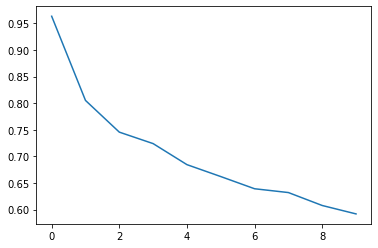

In [0]:
plt.plot(loss_curve)

1. [**Adam and AdamW algorithms**](https://www.fast.ai/2018/07/02/adam-weight-decay/)

2. [**The optimal learning rate during fine-tuning of an artificial neural network**](https://www.mikulskibartosz.name/the-optimal-learning-rate-during-fine-tuning-of-an-artificial-neural-network/)

In [0]:
state_dict = torch.load('/content/cloned-repo/model_epoch_50.pth')